In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder, OrdinalEncoder 
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from scipy.stats import pointbiserialr


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import Counter



import joblib

from datetime import datetime


# 0- Importation du fichier merge preclean

In [2]:
df = pd.read_parquet(r'C:\Users\dimle\Documents\clone_repo\preventive_maintenance\data_preclean_avion.parquet')

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
df.head(3)

,aero_,measure_day_,usure_nouvelle_max_Composants_Critiques,usure_nouvelle_max_Composants_Majeurs,usure_nouvelle_max_Composants_Secondaires,usure_nouvelle_mean_Composants_Critiques,usure_nouvelle_mean_Composants_Majeurs,usure_nouvelle_mean_Composants_Secondaires,time_en_air,etat_voyant,temp,pressure,vibrations,type_model,debut_service,last_maint,en_maintenance,measure_day,temps_de_vol_cumule,etat_voyant_suivant
0,A320_1884,2024-06-04,61.126660,60.781740,59.684620,28.157460,32.796355,29.171363,9.8,0,4.3,907.3,1.763677,A320,2015-12-26,2024-06-01,False,2024-06-04,9.8,1
1,A320_1884,2024-06-05,62.128398,61.547122,60.747186,29.045238,33.699044,30.416709,7.4,1,-24.3,905.9,3.428686,A320,2015-12-26,2024-06-01,False,2024-06-05,17.2,0
2,A320_1884,2024-06-08,62.466823,61.805697,61.106161,29.345163,34.004007,30.837434,2.5,0,-8.4,962.5,1.290613,A320,2015-12-26,2024-06-01,False,2024-06-08,2.5,0


# 1- clean du dataset pour le ML

In [5]:
df['measure_day_'] = pd.to_datetime(df['measure_day_'])
df['last_maint'] = pd.to_datetime(df['last_maint'])

In [6]:
# ajouter la colonne nb de jour depuis la derniere maintenande
# measure_day_ - last_maint

df['nb_jours_maint'] = df.apply(lambda x: x['measure_day_'] - x['last_maint'], axis=1)

In [7]:
# ajout du nombre de jour depuis la mise en service à jour_vol
df['nb_jours_service'] = df.apply(lambda x: x['measure_day_'] - x['debut_service'], axis=1)

In [8]:
# suppression des colonnes date inutile
df = df.drop(columns=['measure_day', 'last_maint', 'debut_service'])

In [9]:
# modification du type de variable pour les ecarts de date (passage en integer depuis un timedelta64[ns] en jour)
df['nb_jours_maint'] = df['nb_jours_maint'].dt.days
df['nb_jours_service'] = df['nb_jours_service'].dt.days

In [10]:
df.head(2)

,aero_,measure_day_,usure_nouvelle_max_Composants_Critiques,usure_nouvelle_max_Composants_Majeurs,usure_nouvelle_max_Composants_Secondaires,usure_nouvelle_mean_Composants_Critiques,usure_nouvelle_mean_Composants_Majeurs,usure_nouvelle_mean_Composants_Secondaires,time_en_air,etat_voyant,temp,pressure,vibrations,type_model,en_maintenance,temps_de_vol_cumule,etat_voyant_suivant,nb_jours_maint,nb_jours_service
0,A320_1884,2024-06-04,61.126660,60.781740,59.684620,28.157460,32.796355,29.171363,9.8,0,4.3,907.3,1.763677,A320,False,9.8,1,3,3083
1,A320_1884,2024-06-05,62.128398,61.547122,60.747186,29.045238,33.699044,30.416709,7.4,1,-24.3,905.9,3.428686,A320,False,17.2,0,4,3084


In [11]:
df.isna().sum()

aero_                                         0
measure_day_                                  0
usure_nouvelle_max_Composants_Critiques       0
usure_nouvelle_max_Composants_Majeurs         0
usure_nouvelle_max_Composants_Secondaires     0
usure_nouvelle_mean_Composants_Critiques      0
usure_nouvelle_mean_Composants_Majeurs        0
usure_nouvelle_mean_Composants_Secondaires    0
time_en_air                                   0
etat_voyant                                   0
temp                                          0
pressure                                      0
vibrations                                    0
type_model                                    0
en_maintenance                                0
temps_de_vol_cumule                           0
etat_voyant_suivant                           0
nb_jours_maint                                0
nb_jours_service                              0
dtype: int64

# 1.bis- Visualisation des data 

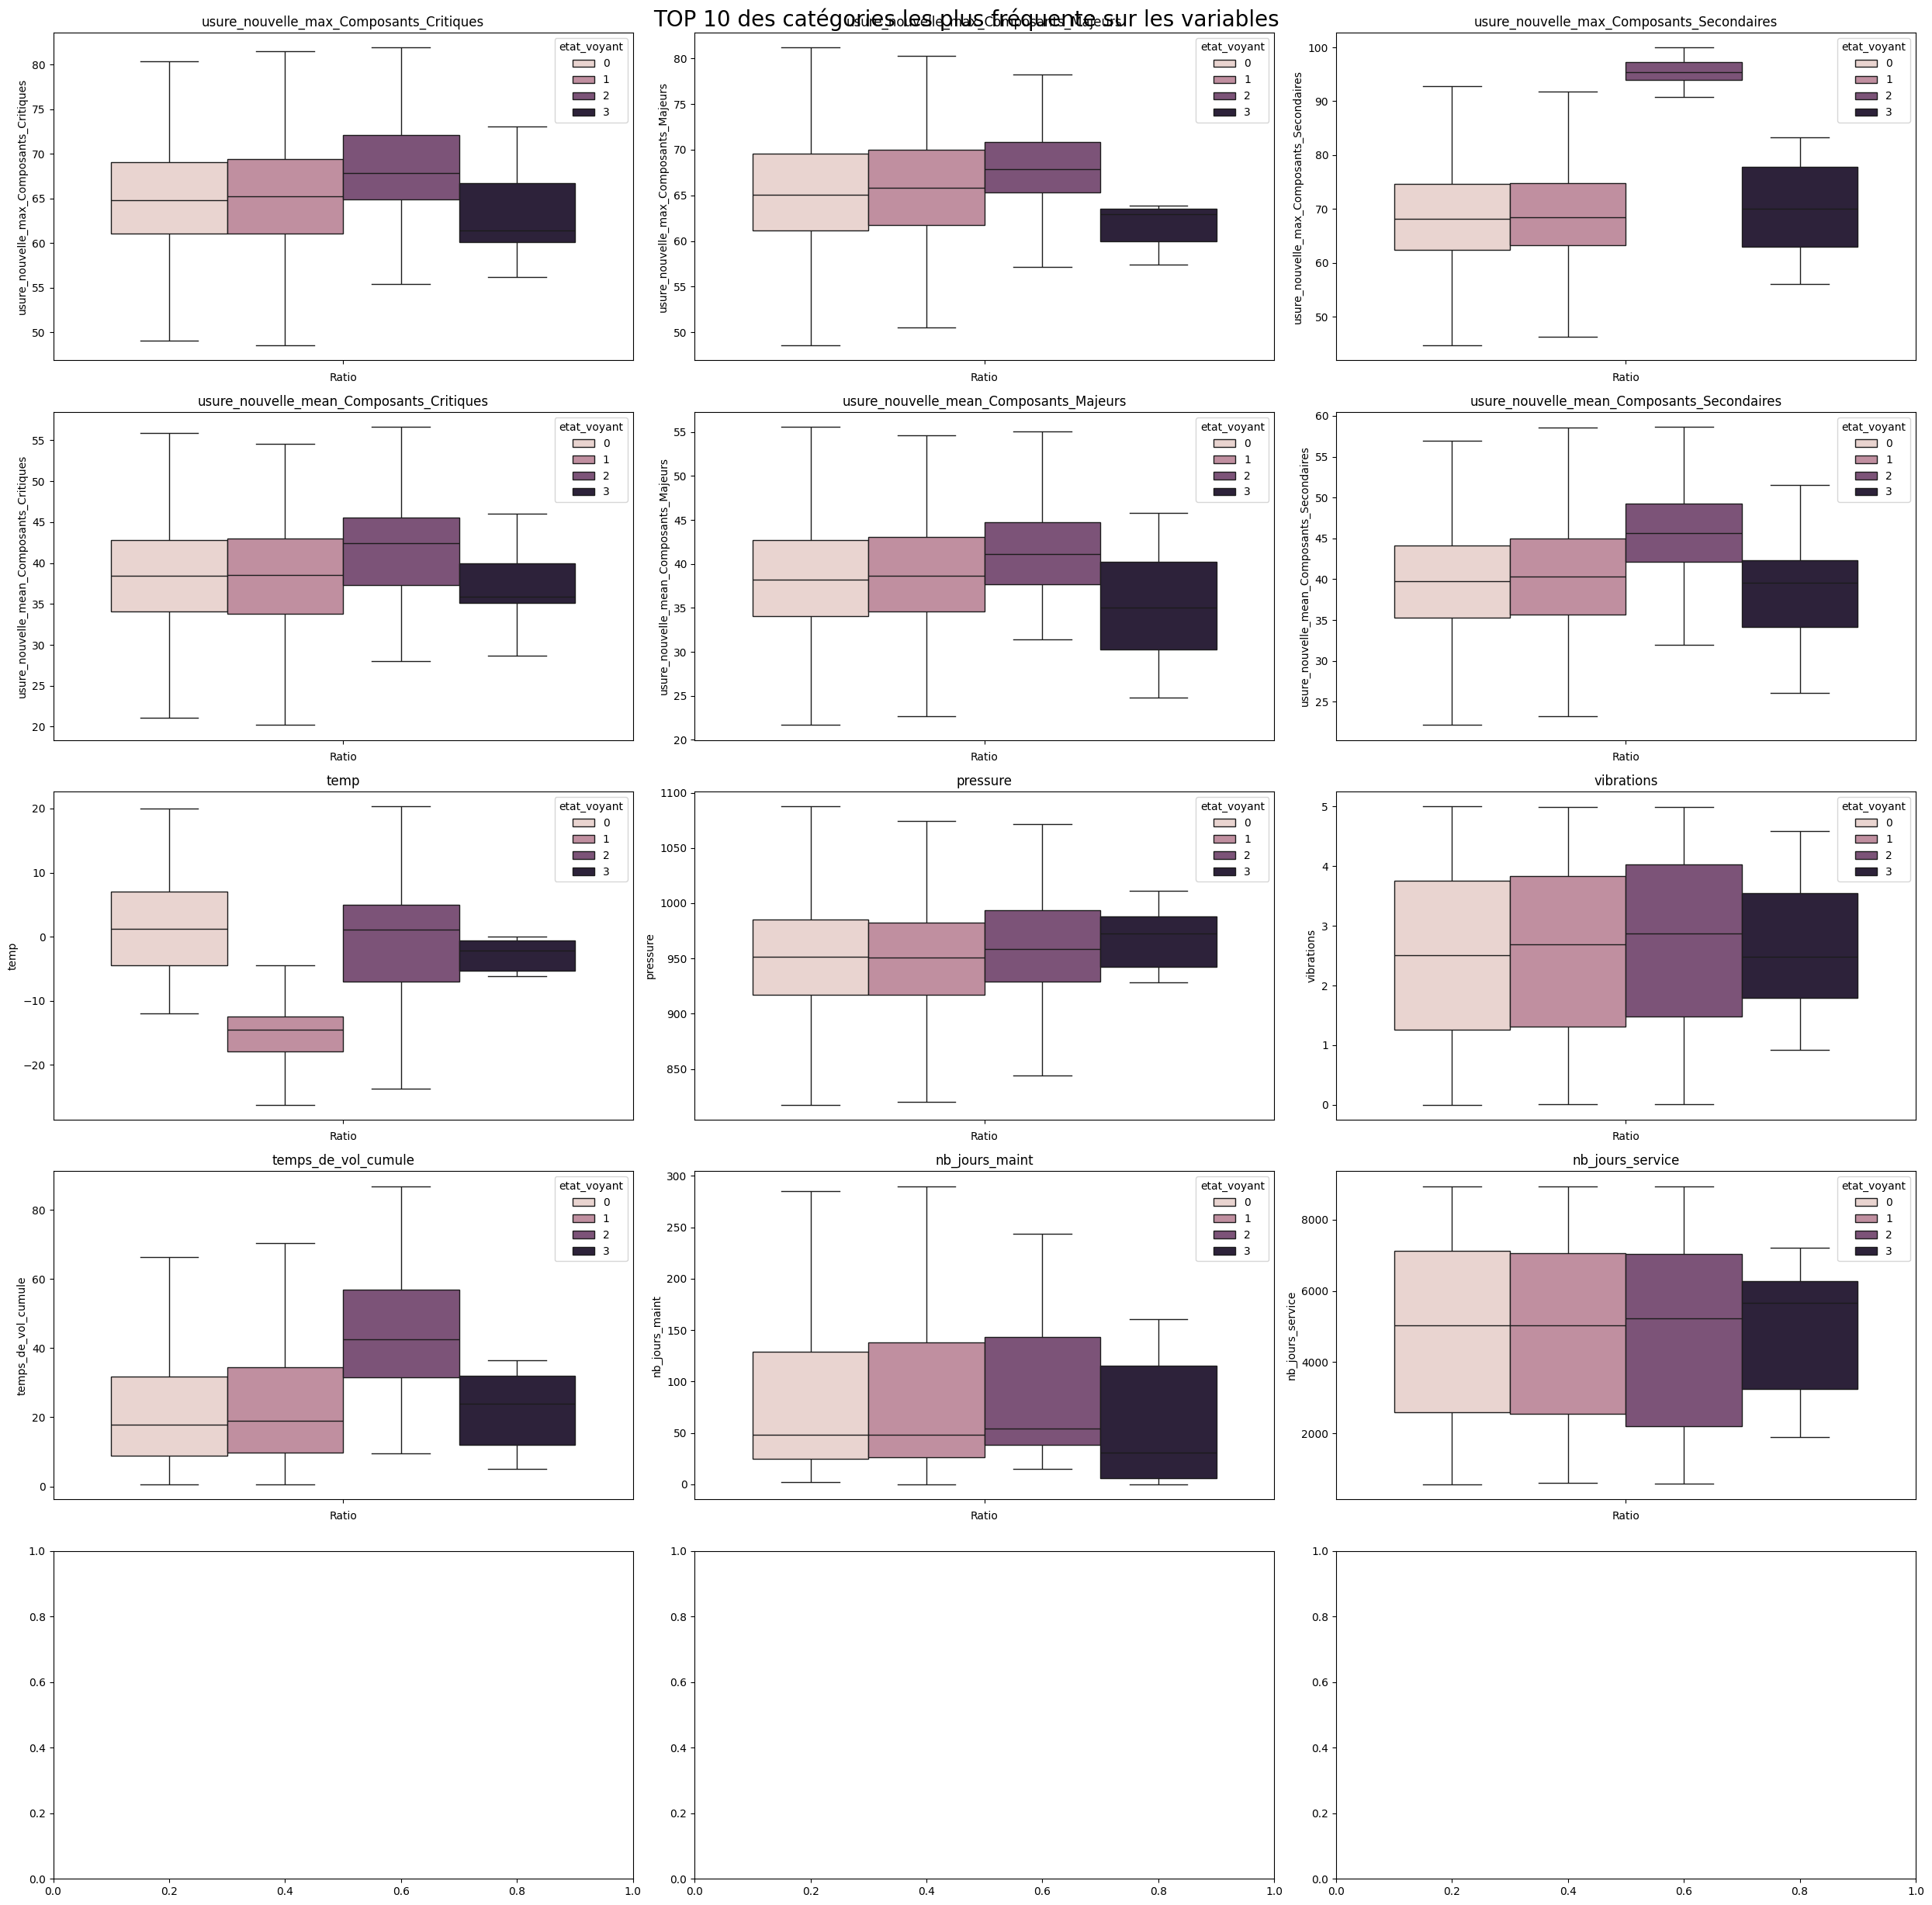

In [12]:
df_num = df[['usure_nouvelle_max_Composants_Critiques',
       'usure_nouvelle_max_Composants_Majeurs',
       'usure_nouvelle_max_Composants_Secondaires',
       'usure_nouvelle_mean_Composants_Critiques',
       'usure_nouvelle_mean_Composants_Majeurs',
       'usure_nouvelle_mean_Composants_Secondaires',
       'temp', 'pressure', 'vibrations',
       'temps_de_vol_cumule', 'nb_jours_maint',
       'nb_jours_service']]

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(5, 3, figsize=(25, 25))
fig.suptitle('TOP 10 des catégories les plus fréquente sur les variables', fontsize=20)
fig.tight_layout(pad=3.0)

# Parcourir chaque colonne et créer un histogramme
for i, col in enumerate(df_num.columns):
    

    sns.boxplot(data=df, y=col,  ax=axes[i//3, i%3], hue='etat_voyant', showfliers= False)
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].set_xlabel('Ratio')
    axes[i//3, i%3].set_ylabel(col)

plt.tight_layout()
plt.show()

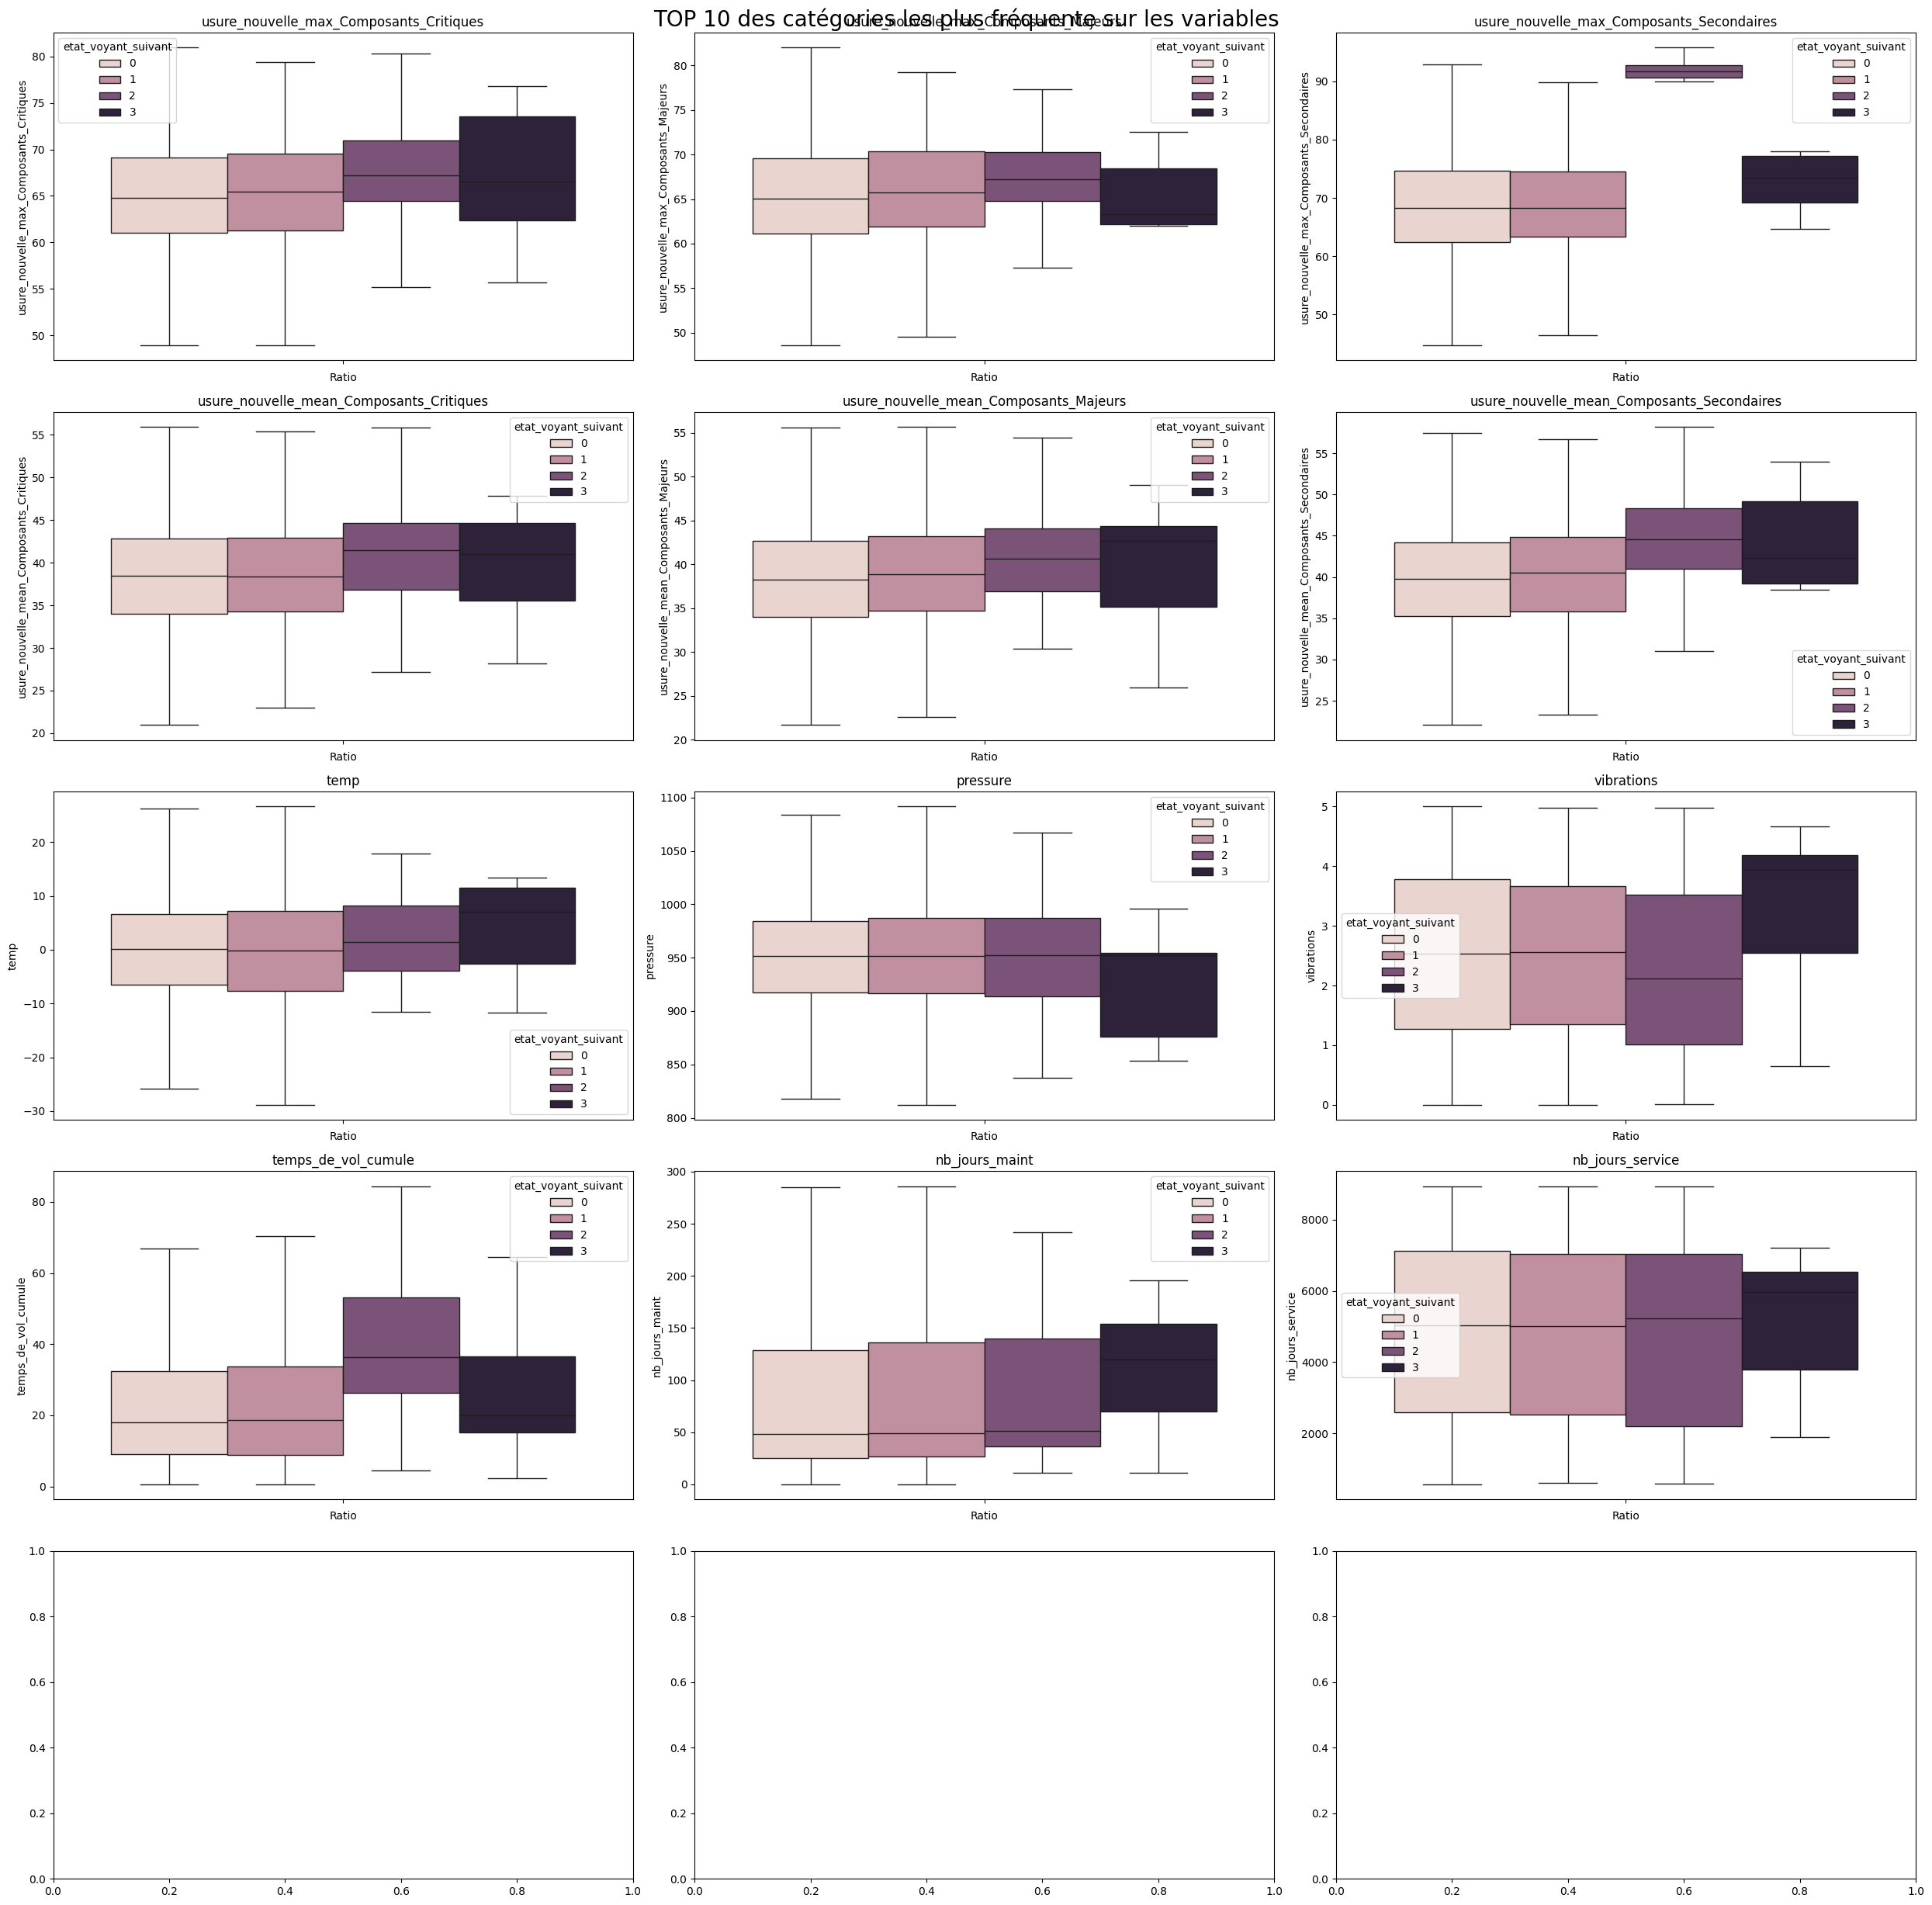

In [13]:
df_num = df[['usure_nouvelle_max_Composants_Critiques',
       'usure_nouvelle_max_Composants_Majeurs',
       'usure_nouvelle_max_Composants_Secondaires',
       'usure_nouvelle_mean_Composants_Critiques',
       'usure_nouvelle_mean_Composants_Majeurs',
       'usure_nouvelle_mean_Composants_Secondaires',
       'temp', 'pressure', 'vibrations',
       'temps_de_vol_cumule', 'nb_jours_maint',
       'nb_jours_service']]

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(5, 3, figsize=(25, 25))
fig.suptitle('TOP 10 des catégories les plus fréquente sur les variables', fontsize=20)
fig.tight_layout(pad=3.0)

# Parcourir chaque colonne et créer un histogramme
for i, col in enumerate(df_num.columns):
    

    sns.boxplot(data=df, y=col,  ax=axes[i//3, i%3], hue='etat_voyant_suivant', showfliers= False)
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].set_xlabel('Ratio')
    axes[i//3, i%3].set_ylabel(col)

plt.tight_layout()
plt.show()

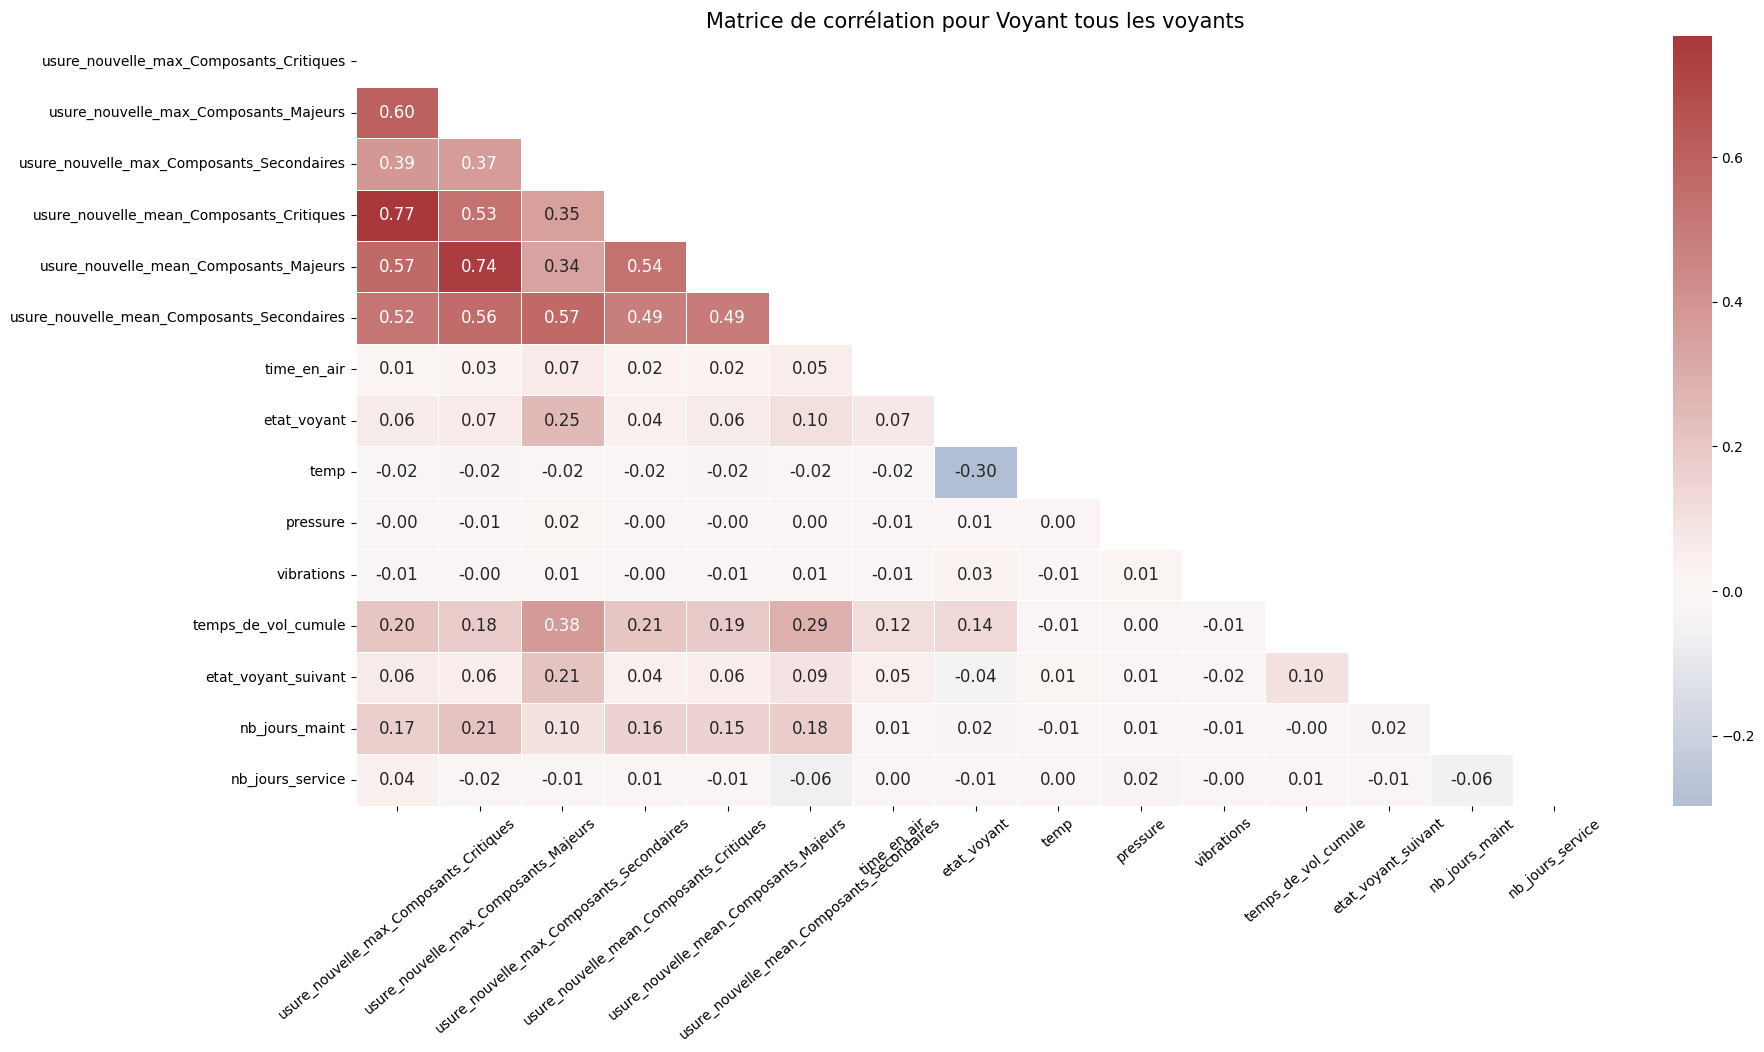

In [14]:
fig_correl, ax_correl = plt.subplots(1,1, figsize = (20,10))

numerical_corr_matrix = df.select_dtypes(include='number').corr()

mask = np.triu(np.ones_like(numerical_corr_matrix, dtype=bool))

annot_kwargs = {
    "fontsize": 12
}

sns.heatmap(numerical_corr_matrix,
                center= 0,
                cmap = sns.color_palette("vlag", as_cmap=True),
                annot= True,
                mask= mask,
                ax=ax_correl,
                linewidths=.5,
                fmt= '.2f',
                annot_kws= annot_kwargs
                )

ax_correl.set_title('Matrice de corrélation pour Voyant tous les voyants', fontsize= 15)
ax_correl.set_xticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 40)
ax_correl.set_yticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 0)

plt.show(fig_correl.figure)

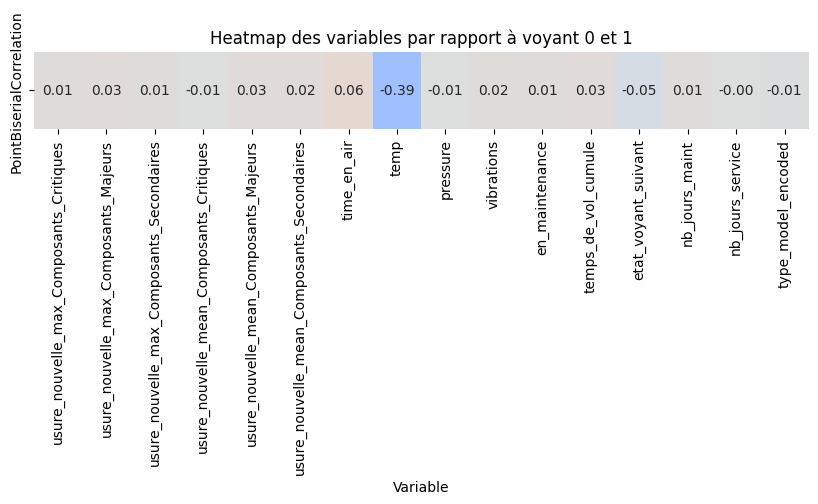

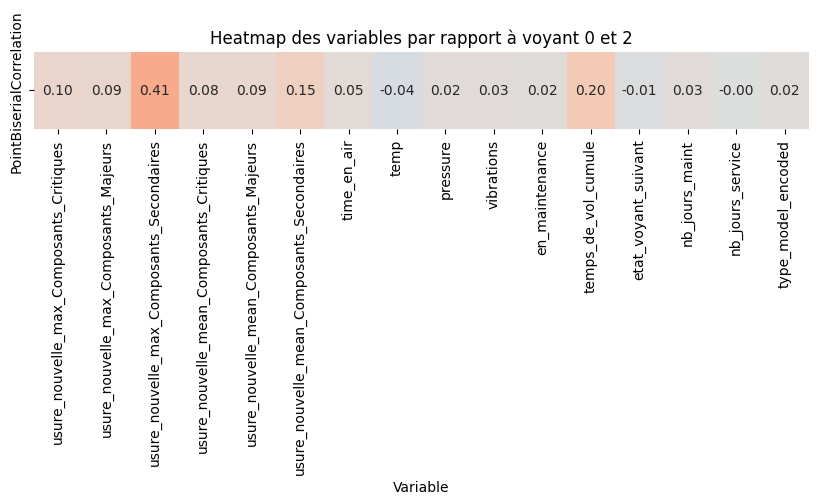

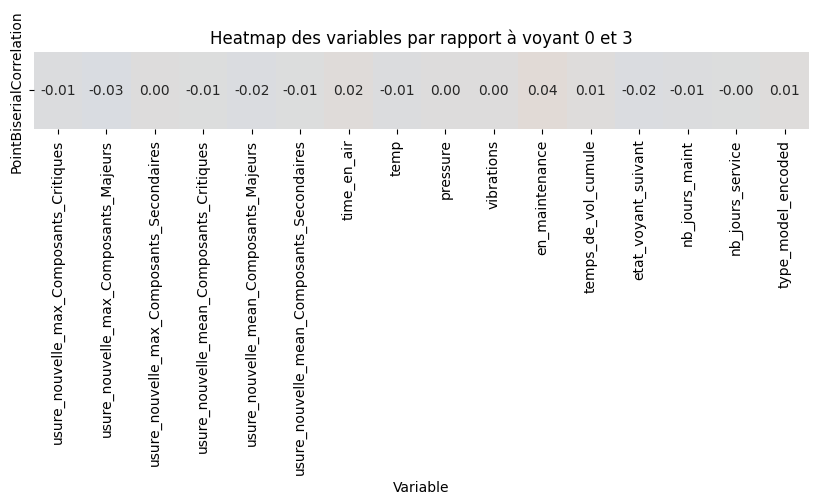

In [15]:
# encodage 0 ou 1 pour la class etat_voyant trié à 3

label_encoder = LabelEncoder()

for i in range(0,4,1):
    if i!=0:
        df_3 = df[(df['etat_voyant']==i) | (df['etat_voyant']==0)].copy()
        df_3['etat_voyant_encoded'] = label_encoder.fit_transform(df_3['etat_voyant'])
        df_3['type_model_encoded'] = label_encoder.fit_transform(df_3['type_model'])
        df_3.drop(['etat_voyant', 'type_model', 'measure_day_'], axis=1, inplace=True)
        continuous_cols = df_3.drop(columns=['etat_voyant_encoded', 'aero_' ])
        # Calculer la corrélation bisériale ponctuelle pour chaque variable continue
        correlations = {}
        for col in continuous_cols.columns:
            correlations[col] = pointbiserialr(df_3['etat_voyant_encoded'], df_3[col])[0]
        # Convertir le dictionnaire en DataFrame pour la heatmap
        corr_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'PointBiserialCorrelation'])
        corr_df.set_index('Variable', inplace=True)
        # créer la figure
        plt.figure(figsize=(10, 1))
        sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', cbar=False, fmt=".2f", vmin=-1, vmax= 1)
        plt.title(f'Heatmap des variables par rapport à voyant {0} et {i}')
        # Affichez la heatmap
        plt.show()

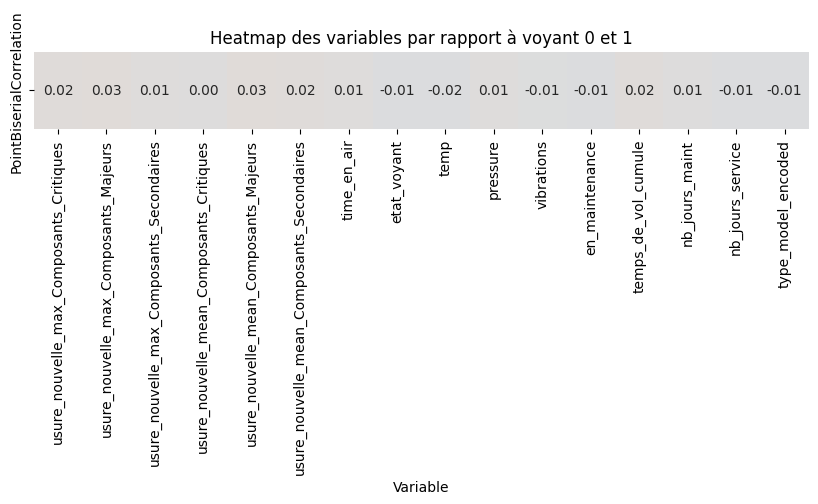

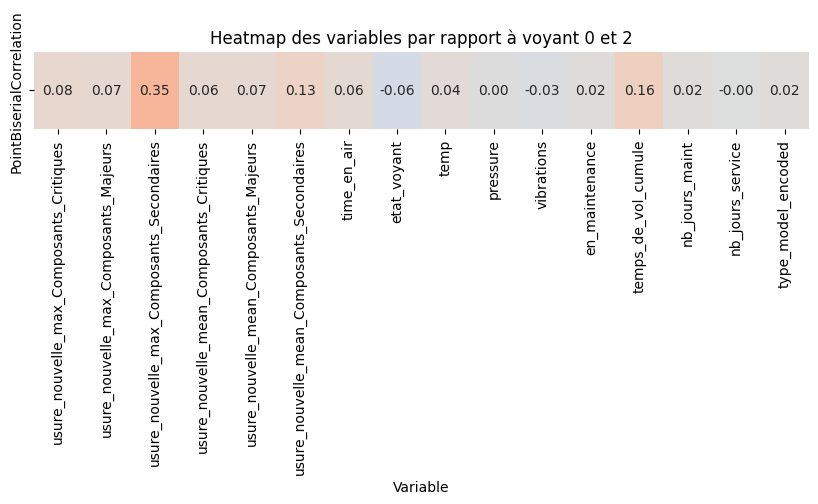

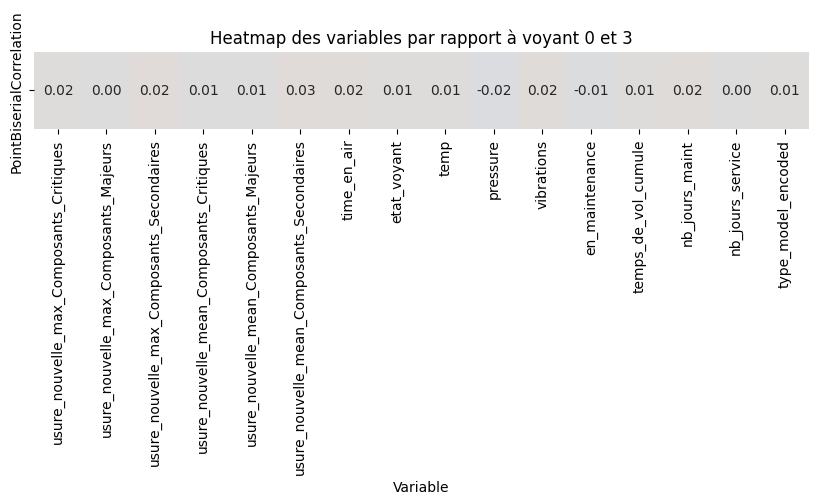

In [16]:
# encodage 0 ou 1 pour la class etat_voyant trié à 3

label_encoder = LabelEncoder()


for i in range(0,4,1):
    if i!=0:
        df_3 = df[(df['etat_voyant_suivant']==i) | (df['etat_voyant_suivant']==0)].copy()
        df_3['etat_voyant_encoded'] = label_encoder.fit_transform(df_3['etat_voyant_suivant'])
        df_3['type_model_encoded'] = label_encoder.fit_transform(df_3['type_model'])
        df_3.drop(['etat_voyant_suivant', 'type_model', 'measure_day_'], axis=1, inplace=True)
        continuous_cols = df_3.drop(columns=['etat_voyant_encoded', 'aero_' ])
        # Calculer la corrélation bisériale ponctuelle pour chaque variable continue
        correlations = {}
        for col in continuous_cols.columns:
            correlations[col] = pointbiserialr(df_3['etat_voyant_encoded'], df_3[col])[0]
        # Convertir le dictionnaire en DataFrame pour la heatmap
        corr_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'PointBiserialCorrelation'])
        corr_df.set_index('Variable', inplace=True)
        # créer la figure
        plt.figure(figsize=(10, 1))
        sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', cbar=False, fmt=".2f", vmin=-1, vmax= 1)
        plt.title(f'Heatmap des variables par rapport à voyant 0 et {i}')
        # Affichez la heatmap
        plt.show()

# 2- Prepa des données et pipeline pour ML

In [17]:
features_std = [
                     'usure_nouvelle_max_Composants_Critiques',
                     'usure_nouvelle_max_Composants_Majeurs',
                     'usure_nouvelle_max_Composants_Secondaires',
                     'usure_nouvelle_mean_Composants_Critiques',
                     'usure_nouvelle_mean_Composants_Majeurs',
                     'usure_nouvelle_mean_Composants_Secondaires',
                     'temp', 'pressure', 'vibrations',
                     'temps_de_vol_cumule', 'nb_jours_maint',
                     'nb_jours_service'
]

features_oneHot = ['type_model']


features_binar =['en_maintenance']

In [18]:
# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))

categ_transformer_onehot = (ImbPipeline( steps= [
    ('OneHot', OneHotEncoder())
]))

categ_transformer_bin = (ImbPipeline( steps= [
    ('bina', OrdinalEncoder())
]))


# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, features_std),
        ('cat_oneHot', categ_transformer_onehot, features_oneHot),
        ('cat_bin', categ_transformer_bin, features_binar)
    ]
)

In [19]:
y = df['etat_voyant'] 

X = df[['usure_nouvelle_max_Composants_Critiques',
        'usure_nouvelle_max_Composants_Majeurs',
        'usure_nouvelle_max_Composants_Secondaires',
        'usure_nouvelle_mean_Composants_Critiques',
        'usure_nouvelle_mean_Composants_Majeurs',
        'usure_nouvelle_mean_Composants_Secondaires',
        'temp', 'pressure', 'vibrations',
        'temps_de_vol_cumule', 'nb_jours_maint',
        'nb_jours_service', 'type_model',
        'en_maintenance']]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

# 3- Essai de modele

## 3.1- Logistic regression

In [21]:
RL_model = XGBClassifier()

In [22]:
pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('model', RL_model)
])

In [23]:
param_dist_xgbc = {
    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__min_child_weight': [1, 2, 3, 4, 5, 6],
    'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__reg_lambda': [1, 0.1, 0.01, 0.001, 0],
    'model__eval_metric': ['mlogloss', 'logloss'],
}


In [24]:
random_search_xgbc = RandomizedSearchCV(
    estimator=pipeline_reg_log,
    param_distributions=param_dist_xgbc,
    n_iter=50,  
    scoring='accuracy',
    verbose=1,
    random_state=42,
    cv=5,
    n_jobs=-1  
)

{'recall_micro', 'neg_mean_absolute_error', 'jaccard_micro', 'neg_root_mean_squared_error', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'balanced_accuracy', 'neg_mean_squared_log_error', 'f1_weighted', 'roc_auc', 'neg_mean_squared_error', 'explained_variance', 'r2', 'recall', 'recall_weighted', 'completeness_score', 'precision_macro', 'neg_brier_score', 'precision', 'neg_mean_gamma_deviance', 'f1_samples', 'f1_macro', 'homogeneity_score', 'recall_samples', 'd2_absolute_error_score', 'v_measure_score', 'precision_samples', 'accuracy', 'roc_auc_ovo_weighted', 'max_error', 'adjusted_mutual_info_score', 'neg_root_mean_squared_log_error', 'jaccard_weighted', 'jaccard_samples', 'positive_likelihood_ratio', 'neg_mean_poisson_deviance', 'neg_negative_likelihood_ratio', 'roc_auc_ovr', 'average_precision', 'precision_weighted', 'neg_mean_absolute_percentage_error', 'neg_median_absolute_error', 'precision_micro', 'neg_log_loss', 'f1', 'matthews_corrcoef', 'rand_score', 'fowlkes_mallows_score', 'jaccard', 'normalized_mutual_info_score', 'top_k_accuracy', 'adjusted_rand_score', 'jaccard_macro', 'f1_micro', 'mutual_info_score', 'recall_macro'}

In [25]:
random_search_xgbc.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_std',
                                                                               Pipeline(steps=[('stdScaller',
                                                                                                StandardScaler())]),
                                                                               ['usure_nouvelle_max_Composants_Critiques',
                                                                                'usure_nouvelle_max_Composants_Majeurs',
                                                                                'usure_nouvelle_max_Composants_Secondaires',
                                                                                'usure_nouvelle_mean_Composants_Critiques',
                                                                                'usure_nouvelle_mean_...
                                                         0.5],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2, 0.3,
                                                                 0.4],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_child_weight': [1, 2, 3, 4,
                                                                    5, 6],
                                        'model__n_estimators': [50, 100, 200,
                                                                300, 400, 500],
                                        'model__reg_alpha': [0, 0.01, 0.1, 1,
                                                             10],
                                        'model__reg_lambda': [1, 0.1, 0.01,
                                                              0.001, 0],
                                        'model__subsample': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [26]:
# Afficher les meilleurs paramètres trouvés
print("Best parameters found: ", random_search_xgbc.best_params_)

# Évaluer le modèle sur l'ensemble de test
best_model_xgbc = random_search_xgbc.best_estimator_

Best parameters found:  {'model__subsample': 0.5, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.01, 'model__n_estimators': 50, 'model__min_child_weight': 5, 'model__max_depth': 5, 'model__learning_rate': 0.3, 'model__gamma': 0.3, 'model__eval_metric': 'logloss', 'model__colsample_bytree': 0.6, 'model__colsample_bynode': 0.6, 'model__colsample_bylevel': 0.9}


In [27]:
y_pred_rl = best_model_xgbc.predict(X_test)

In [28]:
accuracy_rl = accuracy_score(y_test, y_pred_rl)

print(f'Accuracy: {accuracy_rl:.4f}')

Accuracy: 0.9797


In [29]:
class_report_rl = classification_report(y_test, y_pred_rl)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1159
           1       0.99      0.93      0.96       187
           2       0.81      0.78      0.79        32
           3       0.00      0.00      0.00         2

    accuracy                           0.98      1380
   macro avg       0.70      0.68      0.69      1380
weighted avg       0.98      0.98      0.98      1380



c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

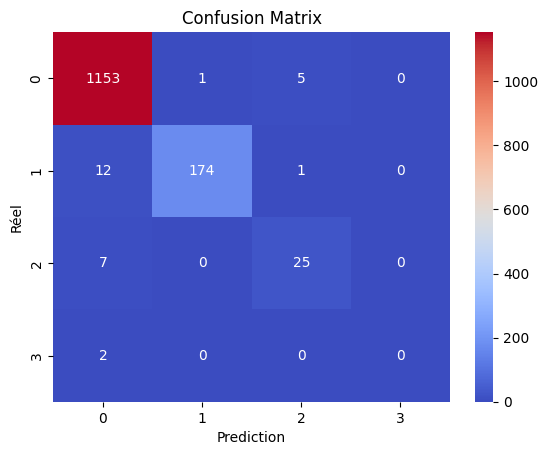

In [30]:
conf_matrix_rl = confusion_matrix(y_test, y_pred_rl)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix')
plt.show()

# 3- Enregistrement du modele

In [31]:

# Enregistrer le modèle dans un fichier
joblib.dump(best_model_xgbc, 'best_model_avion.pkl')

['best_model_avion.pkl']

# 4- Essai de modele avec serie temporelle

In [32]:

# df['year'] = df['measure_day_'].dt.year
# df['month'] = df['measure_day_'].dt.month
# df['day'] = df['measure_day_'].dt.day
# df['dayofweek'] = df['measure_day_'].dt.dayofweek



# Création des valeurs décalées (lagged values)
for lag in range(1, 6):

    # df[f'usure_nouvelle_max_Composants_Critiques_lag_{lag}'] = df['usure_nouvelle_max_Composants_Critiques'].shift(lag)
    df[f'usure_nouvelle_max_Composants_Majeurs_lag_{lag}'] = df['usure_nouvelle_max_Composants_Majeurs'].shift(lag)
    df[f'usure_nouvelle_max_Composants_Secondaires_lag_{lag}'] = df['usure_nouvelle_max_Composants_Secondaires'].shift(lag)
    df[f'usure_nouvelle_mean_Composants_Critiques_lag_{lag}'] = df['usure_nouvelle_mean_Composants_Critiques'].shift(lag)
    # df[f'usure_nouvelle_mean_Composants_Majeurs_lag_{lag}'] = df['usure_nouvelle_mean_Composants_Majeurs'].shift(lag)
    # df[f'usure_nouvelle_mean_Composants_Secondaires_lag_{lag}'] = df['usure_nouvelle_mean_Composants_Secondaires'].shift(lag)
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
    df[f'pressure_lag_{lag}'] = df['pressure'].shift(lag)
    # df[f'vibrations_lag_{lag}'] = df['vibrations'].shift(lag)
    # df[f'temps_de_vol_cumule_lag_{lag}'] = df['temps_de_vol_cumule'].shift(lag)
    df[f'nb_jours_maint_lag_{lag}'] = df['nb_jours_maint'].shift(lag)
    df[f'nb_jours_service_lag_{lag}'] = df['nb_jours_service'].shift(lag)
    # df[f'type_model_lag_{lag}'] = df['type_model'].shift(lag)
    # df[f'en_maintenance_lag_{lag}'] = df['en_maintenance'].shift(lag)


# Suppression des lignes avec des valeurs manquantes dues aux décalages
df = df.dropna()

# Séparation des caractéristiques et de la cible
y = df['etat_voyant'] 

X = df.drop([
        'aero_', 
        'time_en_air', 
        'etat_voyant', 
        'etat_voyant_suivant', 
        'usure_nouvelle_max_Composants_Critiques',
        'usure_nouvelle_max_Composants_Majeurs',
        'usure_nouvelle_max_Composants_Secondaires',
        'usure_nouvelle_mean_Composants_Critiques',
        'usure_nouvelle_mean_Composants_Majeurs',
        'usure_nouvelle_mean_Composants_Secondaires',
        'temp', 
        'pressure', 
        'vibrations',
        'temps_de_vol_cumule', 
        'nb_jours_maint',
        'nb_jours_service', 
        'type_model',
        'en_maintenance'
        ], axis=1)


# Division en ensembles d'entraînement et de test
split_date = datetime(2024, 7, 1)

  # ajuster en fonction de votre dataset
X_train = X[df['measure_day_'] < split_date]
X_test = X[df['measure_day_'] >= split_date]
y_train = y[df['measure_day_'] < split_date]
y_test = y[df['measure_day_'] >= split_date]

# X_train = X_train.drop(['measure_day_'], axis=1)
# X_test = X_test.drop(['measure_day_'], axis=1)

# Entraînement du modèle
RL_model = XGBClassifier()

# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))



# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, X.drop(columns='measure_day_').columns)
    ]
)

pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=1, random_state=42)),
    ('model', RL_model)
])

pipeline_reg_log.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = pipeline_reg_log.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.70


In [33]:
class_report_rl = classification_report(y_test, y_pred)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      2237
           1       0.15      0.22      0.18       381
           2       0.80      0.63      0.71        90
           3       0.00      0.00      0.00         3

    accuracy                           0.70      2711
   macro avg       0.45      0.41      0.42      2711
weighted avg       0.74      0.70      0.72      2711



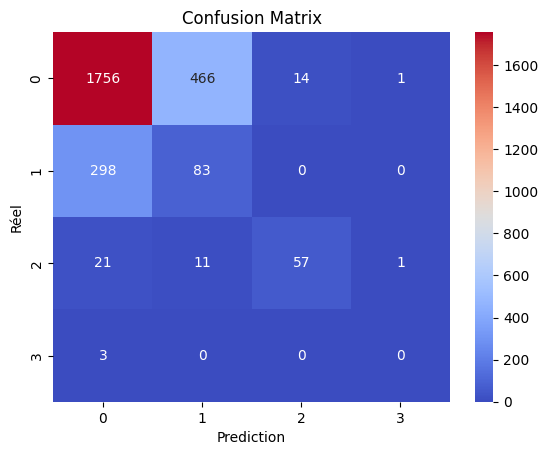

In [34]:
conf_matrix_rl = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix')
plt.show()